### Data load, transform

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


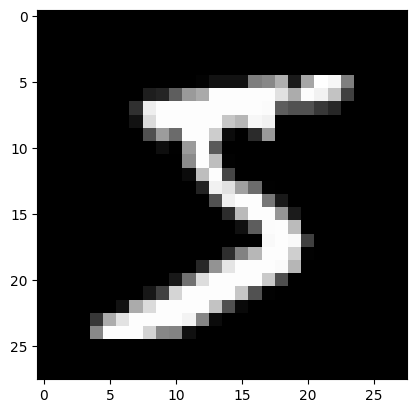

(70000, 784)
(70000,)


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder

mnist = fetch_openml('mnist_784')

X = mnist.data.astype('float32')
y = mnist.target.astype('int')

X /= 255.

# test image
a = X.iloc[0]

current_image = np.array(a).reshape(28, 28) * 255
plt.gray()
plt.imshow(current_image, interpolation='nearest')
plt.show()

print(X.shape)
print(y.shape)

In [ ]:
# copy data
x_copy = X.copy()
y_copy = y.copy()

# one hot encode
encoder = OneHotEncoder(sparse=False, categories='auto')
y_onehot = encoder.fit_transform(y.values.reshape(-1, 1))

print(y_onehot.shape)

(70000, 10)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Activation function

In [ ]:
class Relu:
  def __init__(self, x):
    self.z = x


  def active(self):
    a = np.maximum(self.z, 0)
    return a


  def grd(self):
    grd = np.where(self.z > 0, 1, 0)
    return grd



class LeakyRelu:
  def __init__(self, x):
    self.z = x


  def active(self):
    a = np.maximum(self.z, -0.01 * self.z)
    return a


  def grd(self):
    grd = np.where(self.z > 0, 1, 0.01)
    return grd



class Softmax:
  def __init__(self, x):
    self.z = x


  def active(self):
    large = np.max(self.z, axis=0, keepdims=True)
    return np.exp(self.z - large) / np.sum(np.exp(self.z - large), axis=0, keepdims=True)



class CrossEntropy:
  def __init__(self, pred, y):
    self.pred = pred
    self.y = y


  def loss(self):
    epsilon = 1e-9
    cross_entropy = -np.sum(self.y * np.log(self.pred + epsilon), axis=0, keepdims=True)
    return cross_entropy


### Layer

In [ ]:
class HiddenLayer:
  def __init__(self, w, b):
    self.w = w
    self.b = b


  def forward(self, x):
    self.x = x

    self.z = self.w.T.dot(self.x) + self.b
    a = LeakyRelu(self.z).active()

    return a


  def backward(self, get_grd, lr):
    dz = LeakyRelu(self.z).grd() * get_grd

    db = np.sum(dz)
    dw = self.x.dot(dz.T)

    # gradient clipping -> l2 norm
    norm_dw = np.linalg.norm(dw)
    norm_db = np.linalg.norm(db)

    threshold = 5

    if abs(norm_dw) >= threshold:
      dw = (threshold / abs(norm_dw)) * dw

    if abs(norm_db) >= threshold:
      db = (threshold / abs(norm_db)) * db

    pass_grd = self.w.dot(dz)

    return [dw, db, pass_grd]



class OutLayer:
  def __init__(self, w, b):
    self.w = w
    self.b = b


  def forward(self, x):
    self.x = x
    z = self.w.T.dot(self.x) + self.b
    a = Softmax(z).active()

    return a


  def backward(self, get_grd, lr):
    dz = get_grd

    db = np.sum(dz)
    dw = self.x.dot(dz.T)

    # gradient clipping -> l2 norm
    norm_dw = np.linalg.norm(dw)
    norm_db = np.linalg.norm(db)

    threshold = 5

    if abs(norm_dw) >= threshold:
      dw = (threshold / abs(norm_dw)) * dw

    if abs(norm_db) >= threshold:
      db = (threshold / abs(norm_db)) * db

    pass_grd = self.w.dot(dz)

    return [dw, db, pass_grd]


### Network

In [ ]:
class Network:
  def __init__(self, layer_num, layer_dim):
    self.layer_num = layer_num
    self.layer_dim = layer_dim

    self.w_v = []
    self.b_v = []

    network_dim = [784] + self.layer_dim + [10]

    for idx in range(len(network_dim) - 1):
      w = np.random.randn(network_dim[idx], network_dim[idx + 1])
      b = np.zeros((network_dim[idx + 1], 1))

      self.w_v.append(w); self.b_v.append(b)


  def forward(self, x, y):
    self.layer_v = []
    self.x = x
    self.y = y
    self.pred = None

    layers = len(self.w_v)
    into = x

    for idx in range(layers):
      if idx == layers - 1:
        out = OutLayer(self.w_v[idx], self.b_v[idx])
        self.layer_v.append(out)
        self.pred = out.forward(into)

      else:
        hidden = HiddenLayer(self.w_v[idx], self.b_v[idx])
        self.layer_v.append(hidden)
        into = hidden.forward(into)

    loss = CrossEntropy(self.pred, self.y).loss()
    acc = self.accuracy(self.pred, self.y)

    return [np.mean(loss), acc]


  def backward(self, lr):
    grd_pass = self.pred - self.y
    layers = self.layer_v

    for idx in reversed(range(len(layers))):
      dw, db, grd_pass = layers[idx].backward(grd_pass, lr)

      # weight, bias update here
      self.update(idx, dw, db, lr)


  def update(self, idx, dw, db, lr):
    self.w_v[idx] = self.w_v[idx] - lr * dw
    self.b_v[idx] = self.b_v[idx] - lr * db


  def accuracy(self, pred, y):
    pred = np.argmax(pred, axis=0)
    y = np.argmax(y, axis=0)

    return np.sum(pred == y) / len(y)



### Data split : train dev test

In [ ]:
data = np.array(x_copy).T
label = np.array(y_onehot).T

train_x = data[:, :50000]
train_y = label[:, :50000]

dev_x = data[:, 50000:60000]
dev_y = label[:, 50000:60000]

test_x = data[:, 60000:]
test_y = label[:, 60000:]

print("train shape x, y")
print(train_x.shape)
print(train_y.shape)

print("dev shape x, y")
print(dev_x.shape)
print(dev_y.shape)

print("test shape x, y")
print(test_x.shape)
print(test_y.shape)

train shape x, y
(784, 50000)
(10, 50000)
dev shape x, y
(784, 10000)
(10, 10000)
test shape x, y
(784, 10000)
(10, 10000)


In [ ]:
test_y = train_y[]

### Mini batch *learning*

In [ ]:
# bact_size, epoch 설정
batch_size = 32
epoch = 100

# para -> 은닉층 레이어 수, 은닉층 레이어 차원 설정 : 리스트화
network = Network(1, [10])

data_size = train_x.shape[1]
iteration = data_size // batch_size


for iter in range(epoch):
  # Mini batch
  for idx in range(iteration + 1):
    mini_batch_x = train_x[:, idx * batch_size : (idx + 1) * batch_size]
    mini_batch_y = train_y[:, idx * batch_size : (idx + 1) * batch_size]

    network.forward(mini_batch_x, mini_batch_y)
    network.backward(0.01)

  train_loss, train_acc = network.forward(train_x, train_y)
  val_loss, val_acc = network.forward(dev_x, dev_y)

  print(f"epoch : {iter + 1} / {epoch}, train acc : {train_acc}, val acc : {val_acc}")
  print(train_acc - val_acc)

  # 0.01 이상일 때 학습 멈춤
  if train_acc - val_acc > 0.01:
    print("Early stopping")
    print("#" * 30)
    break

# 최종 모델 평가
test_loss, test_acc = network.forward(test_x, test_y)
print(f"model acc : {test_acc}")

epoch : 1 / 100, train acc : 0.60906, val acc : 0.6202
-0.011139999999999928
epoch : 2 / 100, train acc : 0.7535, val acc : 0.7695
-0.016000000000000014
epoch : 3 / 100, train acc : 0.80656, val acc : 0.8226
-0.016039999999999943
epoch : 4 / 100, train acc : 0.8254, val acc : 0.8399
-0.014499999999999957
epoch : 5 / 100, train acc : 0.83256, val acc : 0.8462
-0.013639999999999985
epoch : 6 / 100, train acc : 0.83934, val acc : 0.8499
-0.010560000000000014
epoch : 7 / 100, train acc : 0.84802, val acc : 0.8587
-0.010680000000000023
epoch : 8 / 100, train acc : 0.85694, val acc : 0.8668
-0.00985999999999998
epoch : 9 / 100, train acc : 0.85522, val acc : 0.8643
-0.009079999999999977
epoch : 10 / 100, train acc : 0.86202, val acc : 0.8687
-0.006680000000000019
epoch : 11 / 100, train acc : 0.85606, val acc : 0.8606
-0.0045399999999999885
epoch : 12 / 100, train acc : 0.8557, val acc : 0.862
-0.006299999999999972
epoch : 13 / 100, train acc : 0.85808, val acc : 0.8632
-0.005120000000000013